In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from modules.LDS import Kalman_EM
from modules.WF_sim import *

from pathlib import Path

# WF simulation

A is not provide! A_demo is used.


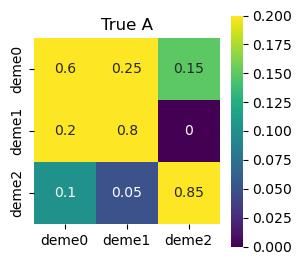

True Neff =  [2000, 2000, 2000]
True measurement noise overdispersion =  [1, 1, 1]


In [4]:
ND = 3 # the number of demes 
T=10 # the number of timepoints
Csn =[1]*ND # strength of measurement noise overdispersion
Npop = [2000]*ND # effective population size
totcounts=np.array([[2000,3000,1500]]*T).T # number of sequences sampled from each region
A,counts,B=WF_sim(Npop,totcounts, Csn, ND, T, A=None,Ntraj=20)

demes=['deme'+str(i) for i in range(ND)]

plt.figure(figsize=[3,3])
sns.heatmap(A,cmap='viridis',vmax=0.2,annot=True,xticklabels=demes, yticklabels=demes,square=True)
plt.title('True A')
plt.show()

print("True Neff = ", Npop)
print("True measurement noise overdispersion = ", Csn )

## HMM-EM

T= Number of timepoints

NA= Number of alleles

ND = Number of demes

* INPUT
    * counts: spatio-temporal data of allele (or lineage) counts, with shape (ND, NA ,T).
    * totcounts: spatio-temporal data of total number of sampled sequences, with shape (ND, T).
* OUTPUT
    * lnLH_record: Record of log likelihood across EM cycles,
    * A_EM: Inferred A.
    * Ne_EM: Inferred effective population size.
    * A_LS: Least squares solution (noises ignored).
    * Csn_EM: Inferred measurment noise overdispersion.

terminate at step=9, DA=0.00046, ratioDNe=0.02141, ratioDCsn=0.0


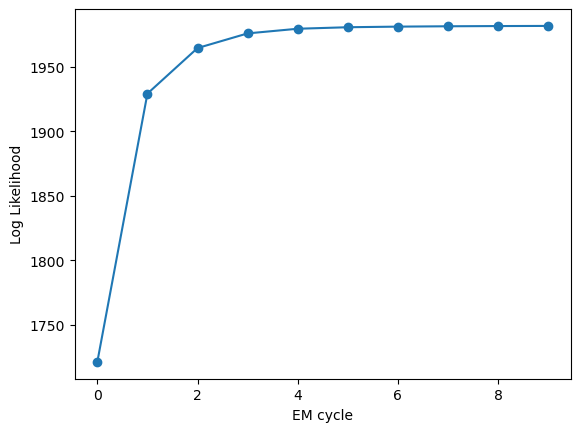

In [5]:
lnLH_record, A_EM, Ne_EM, A_LS,Csn_EM=Kalman_EM(counts=counts+1, 
                                             counts_deme=totcounts, 
                                             em_step_max=100,terminate_th=0.001, 
                                             frac=0.5,noisemode=2,Qprintstep=False)

plt.plot(lnLH_record,marker='o')
plt.xlabel('EM cycle')
plt.ylabel('Log Likelihood')
plt.show()

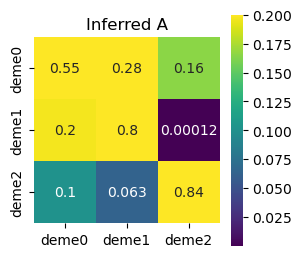

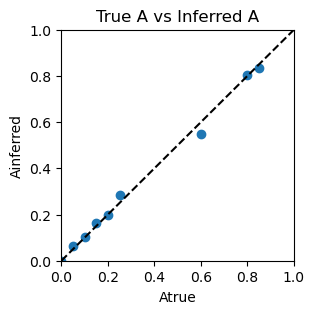

Inferred Neff =  [2827.97224906 2251.5653937  2224.08160237]
Inferred measurement noise overdispersion =  [1. 1. 1.]


In [6]:
plt.figure(figsize=[3,3])
sns.heatmap(A_EM,cmap='viridis',vmax=0.2,annot=True,xticklabels=demes, yticklabels=demes,square=True)
plt.title('Inferred A')
plt.show()

plt.figure(figsize=(3,3))
plt.scatter(A.flatten(),A_EM.flatten())
plt.plot([0,1],'--',color='k')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Atrue')
plt.ylabel('Ainferred')
plt.title('True A vs Inferred A')
plt.show()

print("Inferred Neff = ", Ne_EM)
print("Inferred measurement noise overdispersion = ", Csn_EM)

# HMM-EM and bootstrapping

In [53]:
# Perform bootstrapping 
def bootstrap_data(counts, size):
    ND, Ntraj, T = counts.shape
    return np.array([counts[:,np.random.choice(list(range(Ntraj)),size = Ntraj,replace = True),:] for _ in range(size)])

bootstrap_counts = bootstrap_data(counts, size=10) # only 10 bootstrapped datasets are generated for demonstration purposes.


## Compute in this notebook 

In [27]:

res_A_EM=[]
for BS_counts in bootstrap_counts:
    lnLH_record, A_EM, Ne_EM, A_LS,Csn_EM=Kalman_EM(counts=BS_counts+1, 
                                                counts_deme=totcounts, 
                                                em_step_max=100,terminate_th=0.001, 
                                                frac=0.5,noisemode=2,Qprintstep=False)
    
    res_A_EM.append(A_EM)
res_A_EM=np.array(res_A_EM)


A_EM_mean = np.mean(res_A_EM,axis=0)
A_EM_std  = np.std(res_A_EM,axis=0)

A_EM_mean, A_EM_std 


terminate at step=7, DA=0.00068, ratioDNe=0.02399, ratioDCsn=0.00677
terminate at step=9, DA=0.00096, ratioDNe=0.02126, ratioDCsn=0.00185
terminate at step=11, DA=0.00067, ratioDNe=0.02299, ratioDCsn=0.00831
terminate at step=11, DA=0.00066, ratioDNe=0.02168, ratioDCsn=0.00031
terminate at step=8, DA=0.00064, ratioDNe=0.02352, ratioDCsn=0.01027
terminate at step=11, DA=0.00024, ratioDNe=0.02212, ratioDCsn=0.00653
terminate at step=8, DA=0.00034, ratioDNe=0.02046, ratioDCsn=0.00698
terminate at step=7, DA=0.00026, ratioDNe=0.01905, ratioDCsn=0.00724
terminate at step=12, DA=0.00048, ratioDNe=0.02288, ratioDCsn=0.0
terminate at step=9, DA=0.00022, ratioDNe=0.02156, ratioDCsn=0.00367


(array([[5.42269235e-01, 2.92339294e-01, 1.65391471e-01],
        [1.95650121e-01, 8.04321250e-01, 2.86292654e-05],
        [1.12777252e-01, 5.88416001e-02, 8.28381148e-01]]),
 array([[3.30601336e-02, 1.96168982e-02, 1.86716551e-02],
        [1.20888662e-02, 1.20736785e-02, 2.87440077e-05],
        [2.88548976e-02, 2.63585198e-02, 1.68856768e-02]]))

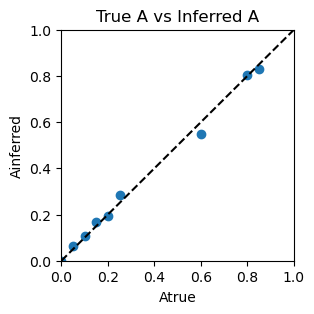

In [57]:
plt.figure(figsize=(3,3))
plt.scatter(A.flatten(),A_EM_mean.flatten())
plt.plot([0,1],'--',color='k')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Atrue')
plt.ylabel('Ainferred')
plt.title('True A vs Inferred A')
plt.show()

## Execute from command line

In [58]:
# Export input data
filename= 'WFsim'
np.save('HMM_EM/input/counts_'+filename+'.npy',bootstrap_counts)
np.save('HMM_EM/input/totcounts_'+filename+'.npy',totcounts)


In [59]:
import os
import subprocess

subprocess.run(["python","HMMEM.py", "WFsim"])  # May raise an error


filename: WFsim
noisemode: 2
ridge: 0.0
step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
terminate at step=16, DA=9e-05, ratioDNe=0.01237, ratioDCsn=0.00495
step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
terminate at step=18, DA=0.0001, ratioDNe=0.00785, ratioDCsn=0.00427
step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
terminate at step=36, DA=0.0001, ratioDNe=0.00813, ratioDCsn=0.00244
step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
terminate at step=22, DA=0

CompletedProcess(args=['python', 'HMMEM.py', 'WFsim'], returncode=0)

In [60]:
res_A_EM=np.load("HMM_EM/output/A_ridge0.0_"+filename+".npy")
res_Ne_EM=np.load("HMM_EM/output/Ne_ridge0.0_"+filename+".npy")
res_Csn_EM=np.load("HMM_EM/output/Csn_ridge0.0_"+filename+".npy")

A_EM_mean = np.mean(res_A_EM,axis=0)
A_EM_std  = np.std(res_A_EM,axis=0)

A_EM_mean, A_EM_std 

(array([[5.47471228e-01, 2.84975016e-01, 1.67553756e-01],
        [1.93801458e-01, 8.05456272e-01, 7.42270628e-04],
        [1.06722312e-01, 6.29104280e-02, 8.30367260e-01]]),
 array([[0.01951604, 0.01134944, 0.01412968],
        [0.01778059, 0.01758707, 0.00143003],
        [0.03392765, 0.02302089, 0.01700497]]))

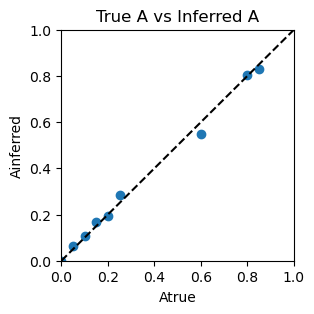

In [61]:
plt.figure(figsize=(3,3))
plt.scatter(A.flatten(),A_EM_mean.flatten())
plt.plot([0,1],'--',color='k')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Atrue')
plt.ylabel('Ainferred')
plt.title('True A vs Inferred A')
plt.show()

## HMM-MCMC (C++)

T= Number of timepoints

NA= Number of alleles

ND = Number of demes

* INPUT
    * counts: spatio-temporal data of allele (or lineage) counts. CSV file with shape (TxNA, ND). The frequencies of the i-th lineage at time t appears at the (i-1)*T + t -th row.
    * totcounts: spatio-temporal data of total number of sampled sequences. CSV file with shape (T, ND).
* OUTPUT
    * A_MCMC: Posterior distribution of A.
    * Ne_MCMC: Posterior distribution of effective population size.
    * Csn_MCMC: Posterior distribution of measurment noise overdispersion.
from modules.HMMtools import *

In [266]:
dir_IO ='demo'
filename='WFsim'

In [268]:
MCMC_dir = 'HMM_MCMC/'

inpath=MCMC_dir+'input/'#+dir_IO+'/'
Path(inpath).mkdir(parents=True, exist_ok=True)

ND,Nmut,tmax  = counts.shape

counts_  = counts.transpose()
shapelst=list(counts_.shape)

aux=np.vstack([counts_[:, i, :] for i in range(Nmut)])

np.savetxt(inpath+'counts_'+filename+'.csv', aux, fmt="%d", delimiter=",")
np.savetxt(inpath+'totcounts_'+filename+'.csv', totcounts.transpose(), fmt="%d", delimiter=",")
np.savetxt(inpath+'shape_'+filename+'.csv', shapelst, fmt="%d", delimiter=",") #  shapelist = #timepoints, #trajectories, #demes
    

In [ ]:
import os
import subprocess
try:
    os.chdir("HMM_MCMC/")
    subprocess.run(["./NI_MCMC", "-f", "WFsim","-m", "50000", "-n","2"])  # May raise an error
finally:
    os.chdir('..')



Filename: WFsim
0: IF 0, C is inferred:
reading input/shape_WFsim.csv
T=10, Nlin=20, Ndeme=3
noisemode=2
nonDB
reading input/counts_WFsim.csv
reading input/totcounts_WFsim.csv
Counts
@0 :2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 
@1 :3000 3000 3000 3000 3000 3000 3000 3000 3000 3000 
@2 :1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 

Aold
 0.592348  0.254599  0.153052
 0.254599   0.73025 0.0151508
 0.153052 0.0151508  0.831797
logLH_old1898.68479180
Step = 2500,  acc = 8.00000000%, lnLH=1903.443074, DBbroken = 0.04
Step = 5000,  acc = 7.00%, lnLH=1904.718594, DBbroken = 0.06
Step = 7500,  acc = 7.00%, lnLH=1905.444416, DBbroken = 0.07
Step = 10000,  acc = 7.00%, lnLH=1906.888214, DBbroken = 0.02
Step = 12500,  acc = 7.00%, lnLH=1904.725886, DBbroken = 0.05
Step = 15000,  acc = 7.00%, lnLH=1905.150997, DBbroken = 0.08
Step = 17500,  acc = 8.00%, lnLH=1906.891480, DBbroken = 0.00
Step = 20000,  acc = 7.00%, lnLH=1897.465795, DBbroken = 0.03
Step = 22500,  acc = 6.00%, lnLH=1

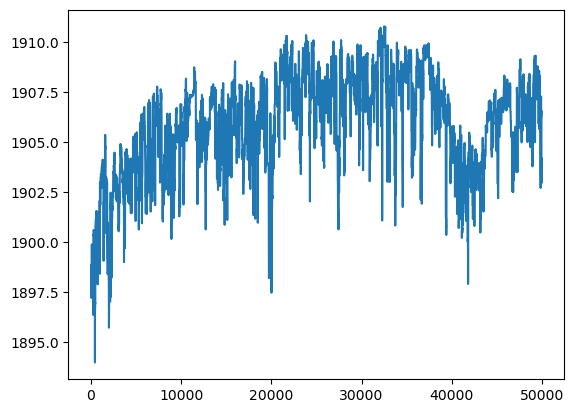

In [269]:
A_mcmc=np.loadtxt(MCMC_dir+'output/A_'+filename+'.csv',delimiter=',')
Ne_mcmc=np.loadtxt(MCMC_dir+'output/Ne_'+filename+'.csv',delimiter=',')
C_mcmc=np.loadtxt(MCMC_dir+'output/C_'+filename+'.csv',delimiter=',')
logLH_mcmc=np.loadtxt(MCMC_dir+'output/logLH_'+filename+'.csv',delimiter=',')

A_mcmc=np.array([ i.reshape((Ne_mcmc.shape[1],Ne_mcmc.shape[1])) for i in A_mcmc])

plt.plot(logLH_mcmc[:,0],logLH_mcmc[:,1])
plt.show()

In [270]:
# Burn-in
burn_in=int(0.5*len(A_mcmc))
A_mcmc = A_mcmc[burn_in:]
Ne_mcmc= Ne_mcmc[burn_in:]
C_mcmc = C_mcmc[burn_in:]


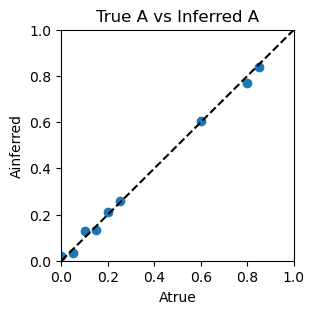

Inferred Neff =  [1827.321278 1485.65646  1727.911692]
Inferred measurement noise overdispersion =  [1.29273413 1.18138973 1.17137445]


In [271]:

plt.figure(figsize=(3,3))
plt.scatter(A.flatten(),np.mean(A_mcmc,axis=0).flatten())
plt.plot([0,1],'--',color='k')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Atrue')
plt.ylabel('Ainferred')
plt.title('True A vs Inferred A')
plt.show()

print("Inferred Neff = ", np.mean(Ne_mcmc,axis=0))
print("Inferred measurement noise overdispersion = ", np.mean(C_mcmc,axis=0))